In [1]:
!splitcode --version
!kallisto version
!fastq-dump --version

splitcode, version 0.30.0
kallisto, version 0.51.1

fastq-dump : 3.2.1



In [ ]:
# Found at https://www.ncbi.nlm.nih.gov/sra?term=SRX23254918
# Retrieve SRA Parse Data
!fastq-dump --outdir FASTA --gzip --skip-technical  --readids --dumpbase --split-files --clip --read-filter pass SRR27585877

Read 23911321 spots for SRR27585877
Written 23911321 spots for SRR27585877


In [ ]:
# Change names of file so easier to read
!mv FASTA/SRR27585877_pass_1.fastq.gz FASTA/raw_Parse_9_R1.fastq.gz
!mv FASTA/SRR27585877_pass_2.fastq.gz FASTA/raw_Parse_9_R2.fastq.gz

In [ ]:
# Extract all reads
!splitcode -c parse_extraction/config_correct.txt --nFastqs=2 --gzip \
    --assign -o FASTA/Parse_9_R1.fastq.gz,FASTA/Parse_9_R2.fastq.gz \
    --outb=FASTA/barcodes/parse_barcodes.fastq --mapping=run_info/parse_mapping.txt --summary=run_info/parse_summary.txt \
    FASTA/raw_Parse_9_R1.fastq.gz FASTA/raw_Parse_9_R2.fastq.gz -t 2

* Using a list of 384 tags (vector size: 384; map size: 8,858; num elements in map: 12,672)
* will process sample 1: FASTA/raw_Parse_9_R1.fastq.gz
                         FASTA/raw_Parse_9_R2.fastq.gz
21M reads processed (84.2% assigned)
done 
* processed 23,911,321 reads, 20,098,558 reads were assigned


In [ ]:
# Divide the reads into different wells

with open("parse_extraction/keep_wells.txt", "w") as keep, open("parse_extraction/config_wells.txt", "w") as config:
    n = 0
    with open("parse_extraction/r1_R.txt", "r") as R:
        keep.truncate()
        config.truncate()
        config.write("tags\tlocations\tdistances\n")

        for line in R:
            n += 1
            keep.write(line.strip() + "\t" +  "FASTA/wells/randO_well_" + str(n) + "\n")
            config.write(line.strip() + "\t" + "1:78:86" + "\t\t" + "1" + "\n")

    n = 0
    with open("parse_extraction/r1_T.txt", "r") as T:
        for line in T:
            n += 1
            keep.write(line.strip() + "\t" +  "FASTA/wells/polyT_well_" + str(n) + "\n")
            config.write(line.strip() + "\t" + "1:78:86" + "\t\t" + "1" + "\n")

In [ ]:
# Extract by well
!splitcode --gzip --keep-r1-r2 --keep=parse_extraction/keep_wells.txt -c parse_extraction/config_wells.txt \
    --nFastqs=2 --no-output --no-outb \
    FASTA/raw_Parse_9_R1.fastq.gz FASTA/raw_Parse_9_R2.fastq.gz -t 2

* Using a list of 192 tags (vector size: 192; map size: 5,885; num elements in map: 6,336)
* will process sample 1: FASTA/raw_Parse_9_R1.fastq.gz
                         FASTA/raw_Parse_9_R2.fastq.gz
21M reads processed         
done 
* processed 23,911,321 reads


In [ ]:
# Extract polyT reads
!splitcode -c parse_extraction/config_RT_polyT.txt --nFastqs=2 --gzip \
    --assign -o FASTA/Parse_polyT_9_R1.fastq.gz,FASTA/Parse_polyT_9_R2.fastq.gz \
    --outb=FASTA/barcodes/polyT_barcodes.fastq --mapping=run_info/polyT_mapping.txt --summary=run_info/polyT_summary.txt \
    FASTA/raw_Parse_9_R1.fastq.gz FASTA/raw_Parse_9_R2.fastq.gz -t 2

* Using a list of 288 tags (vector size: 288; map size: 6,072; num elements in map: 9,504)
* will process sample 1: FASTA/raw_Parse_9_R1.fastq.gz
                         FASTA/raw_Parse_9_R2.fastq.gz
* processing the reads ...^C


In [ ]:
# Extract randO reads
!splitcode -c parse_extraction/config_RT_randO.txt --nFastqs=2 --gzip \
    --assign -o FASTA/Parse_randO_9_R1.fastq.gz,FASTA/Parse_randO_9_R2.fastq.gz \
    --outb=FASTA/barcodes/randO_barcodes.fastq --mapping=run_info/randO_mapping.txt --summary=run_info/randO_summary.txt \
    FASTA/raw_Parse_9_R1.fastq.gz FASTA/raw_Parse_9_R2.fastq.gz -t 2

* Using a list of 288 tags (vector size: 288; map size: 6,079; num elements in map: 9,504)
* will process sample 1: FASTA/raw_Parse_9_R1.fastq.gz
                         FASTA/raw_Parse_9_R2.fastq.gz
21M reads processed (44.1% assigned)
done 
* processed 23,911,321 reads, 10,540,049 reads were assigned


In [ ]:
# Download mouse genome. This experiment used C57BL/6N (Black 6) mice, so we can use a general reference genome. 
!kb ref -d mouse -i index.idx -g t2g.txt

[2025-07-08 12:55:48,138]    INFO [download] Downloading files for mouse (standard workflow) from https://github.com/pachterlab/kallisto-transcriptome-indices/releases/download/v1/mouse_index_standard.tar.xz to tmp/mouse_index_standard.tar.xz
100%|██████████████████████████████████████| 82.8M/82.8M [00:04<00:00, 17.7MB/s]
[2025-07-08 12:55:53,070]    INFO [download] Extracting files from tmp/mouse_index_standard.tar.xz


In [ ]:
# Prepare batch file to pseudalign reads by well
with open("parse_extraction/batch_wells.txt", "w") as batch:
    batch.truncate()
    for n in range(1,97):
        batch.write("RandO_Well" + str(n) + "\tFASTA/wells/randO_well_" + str(n) + "_R1.fastq.gz\tFASTA/wells/randO_well_" + str(n) + "_R2.fastq.gz\n")
    for n in range(1,97):
        batch.write("PolyT_Well" + str(n) + "\tFASTA/wells/polyT_well_" + str(n) + "_R1.fastq.gz\tFASTA/wells/polyT_well_" + str(n) + "_R2.fastq.gz\n")

In [ ]:
# Pseudoalign all parse reads
!kb count --overwrite --h5ad -r parse_extraction/replace.txt -i index.idx -g t2g.txt -x SPLIT-SEQ -o parse_out FASTA/raw_Parse_9_R1.fastq.gz FASTA/raw_Parse_9_R2.fastq.gz

[2025-07-15 15:09:20,187]    INFO [count] Using index index.idx to generate BUS file to parse_out from
[2025-07-15 15:09:20,187]    INFO [count]         FASTA/raw_Parse_9_R1.fastq.gz
[2025-07-15 15:09:20,187]    INFO [count]         FASTA/raw_Parse_9_R2.fastq.gz
[2025-07-15 15:13:32,920]    INFO [count] Sorting BUS file parse_out/output.bus to parse_out/tmp/output.s.bus
[2025-07-15 15:13:35,470]    INFO [count] On-list not provided
[2025-07-15 15:13:35,471]    INFO [count] Copying pre-packaged SPLIT-SEQ on-list to parse_out
[2025-07-15 15:13:35,474]    INFO [count] Inspecting BUS file parse_out/tmp/output.s.bus
[2025-07-15 15:13:37,012]    INFO [count] Correcting BUS records in parse_out/tmp/output.s.bus to parse_out/tmp/output.s.c.bus with on-list parse_out/splitseq_version2_whitelist.txt
[2025-07-15 15:13:38,327]    INFO [count] Sorting BUS file parse_out/tmp/output.s.c.bus to parse_out/output.unfiltered.bus
[2025-07-15 15:13:40,573]    INFO [count] Generating count matrix parse_out/

In [ ]:
# Pseudoalign parse reads by well
!kb count --overwrite --h5ad -i index.idx -g t2g.txt -x SPLIT-SEQ -o wells_out --batch-barcodes parse_extraction/batch_wells.txt

[2025-07-15 09:35:33,343]    INFO [count] Using index index.idx to generate BUS file to wells_out from
[2025-07-15 09:35:33,344]    INFO [count]         /Users/iman/Desktop/Analyses/10x v Parse/Analysis 1/wells_out/tmp/tmpfj9zll_d
[2025-07-15 09:39:05,382]    INFO [count] Sorting BUS file wells_out/output.bus to wells_out/tmp/output.s.bus
[2025-07-15 09:39:07,739]    INFO [count] On-list not provided
[2025-07-15 09:39:07,740]    INFO [count] Copying pre-packaged SPLIT-SEQ on-list to wells_out
[2025-07-15 09:39:07,744]    INFO [count] Inspecting BUS file wells_out/tmp/output.s.bus
[2025-07-15 09:39:09,269]    INFO [count] Correcting BUS records in wells_out/tmp/output.s.bus to wells_out/tmp/output.s.c.bus with on-list wells_out/splitseq_version2_whitelist.txt
[2025-07-15 09:39:10,612]    INFO [count] Sorting BUS file wells_out/tmp/output.s.c.bus to wells_out/output.unfiltered.bus
[2025-07-15 09:39:12,760]    INFO [count] Generating count matrix wells_out/counts_unfiltered/cells_x_genes 

In [ ]:
# Perform pseudoalignment of polyT reads
!kb count --overwrite --h5ad -i index.idx -g t2g.txt -x SPLIT-SEQ -o polyT_out FASTA/Parse_polyT_9_R1.fastq.gz FASTA/Parse_polyT_9_R2.fastq.gz

[2025-07-13 22:11:13,129]    INFO [count] Using index index.idx to generate BUS file to polyT_out from
[2025-07-13 22:11:13,129]    INFO [count]         FASTA/Parse_polyT_9_R1.fastq.gz
[2025-07-13 22:11:13,129]    INFO [count]         FASTA/Parse_polyT_9_R2.fastq.gz
[2025-07-13 22:13:23,199]    INFO [count] Sorting BUS file polyT_out/output.bus to polyT_out/tmp/output.s.bus
[2025-07-13 22:13:25,560]    INFO [count] On-list not provided
[2025-07-13 22:13:25,560]    INFO [count] Copying pre-packaged SPLIT-SEQ on-list to polyT_out
[2025-07-13 22:13:25,587]    INFO [count] Inspecting BUS file polyT_out/tmp/output.s.bus
[2025-07-13 22:13:26,942]    INFO [count] Correcting BUS records in polyT_out/tmp/output.s.bus to polyT_out/tmp/output.s.c.bus with on-list polyT_out/splitseq_version2_whitelist.txt
[2025-07-13 22:13:28,159]    INFO [count] Sorting BUS file polyT_out/tmp/output.s.c.bus to polyT_out/output.unfiltered.bus
[2025-07-13 22:13:30,517]    INFO [count] Generating count matrix polyT_

In [ ]:
# Perform pseudoalignment of randO reads and give same barcodes as polyT reads
!kb count --overwrite --h5ad --strand forward -r parse_extraction/replace.txt -i index.idx -g t2g.txt -x SPLIT-SEQ -o randO_out FASTA/Parse_randO_9_R1.fastq.gz FASTA/Parse_randO_9_R2.fastq.gz

[2025-07-15 20:19:31,980]    INFO [count] Using index index.idx to generate BUS file to randO_out from
[2025-07-15 20:19:31,980]    INFO [count]         FASTA/Parse_randO_9_R1.fastq.gz
[2025-07-15 20:19:31,980]    INFO [count]         FASTA/Parse_randO_9_R2.fastq.gz
[2025-07-15 20:21:16,730]    INFO [count] Sorting BUS file randO_out/output.bus to randO_out/tmp/output.s.bus
[2025-07-15 20:21:19,086]    INFO [count] On-list not provided
[2025-07-15 20:21:19,087]    INFO [count] Copying pre-packaged SPLIT-SEQ on-list to randO_out
[2025-07-15 20:21:19,089]    INFO [count] Inspecting BUS file randO_out/tmp/output.s.bus
[2025-07-15 20:21:20,413]    INFO [count] Correcting BUS records in randO_out/tmp/output.s.bus to randO_out/tmp/output.s.c.bus with on-list randO_out/splitseq_version2_whitelist.txt
[2025-07-15 20:21:21,629]    INFO [count] Sorting BUS file randO_out/tmp/output.s.c.bus to randO_out/output.unfiltered.bus
[2025-07-15 20:21:23,803]    INFO [count] Generating count matrix randO_

In [1]:
# Import packages
import anndata
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd
from pybiomart import Server
from scipy.stats import pearsonr

# Preprocess

In [2]:
# Read in the data
wells_data = anndata.read_h5ad('wells_out/counts_unfiltered/adata.h5ad')
polyT_data = anndata.read_h5ad('polyT_out/counts_unfiltered/adata.h5ad')
randO_data = anndata.read_h5ad('randO_out/counts_unfiltered_modified/adata.h5ad')
parse_data = anndata.read_h5ad('parse_out/counts_unfiltered_modified/adata.h5ad')

In [3]:
# Add in metadata and begin initial processing
datasets = [wells_data, polyT_data, randO_data, parse_data]
data_names = ['wells', 'polyT', 'randO', 'parse']

for data, name in zip(datasets, data_names):
    data.var["gene_codes"] = data.var.index.tolist()

    gene_names = []

    with open(name + '_out/counts_unfiltered/cells_x_genes.genes.names.txt', 'r') as file:
        for line in file:
            gene_names.append(line.strip())

    data.var_names = gene_names

    data.obs['n_genes'] = data.X.astype(bool).sum(axis=1).A1
    data.var['n_cells'] = data.X.astype(bool).sum(axis=0).A1
    data.obs['n_counts'] = data.X.sum(axis=1).A1
    sc.pp.filter_genes(data, min_cells=1)
    sc.pp.filter_cells(data, min_genes=1)

In [4]:
# Add polyT and randO read counts to parse data

parse_data.obs['polyT_reads'] = 0
parse_data.obs.loc[polyT_data.obs_names, 'polyT_reads'] = polyT_data.obs['n_counts']

parse_data.obs['randO_reads'] = 0
parse_data.obs.loc[randO_data.obs_names, 'randO_reads'] = randO_data.obs['n_counts']

In [5]:
## This is a bit strange. May want to figure out why this is
print(parse_data.obs[parse_data.obs['polyT_reads'] + parse_data.obs['randO_reads'] != parse_data.obs['n_counts']])

                          n_genes  n_counts  polyT_reads  randO_reads
barcode                                                              
AACAACCAAGTGGTCACACTTTCA     4914   16341.0         7704         8640
AACAACCAGTCGTAGAATCCTTAC     1693    2901.0         1566         1337
AACCGAGAAGTCACTAATCCTTAC     3004    6745.0         3627         3122
AACCGAGATGAAGAGATAAATATC     1027    1540.0          798          743
AACGCTTAAATCCGTCATCCTTAC      734    1083.0          676          408
...                           ...       ...          ...          ...
TTCACGCACACCTTACCCTTTGCA     1213    2025.0          704         1322
TTCACGCAGAGTTAGCCACTTTCA     1288    2084.0          971         1114
TTCACGCATATCAGCAATGCTGCT     1035    1675.0          993          683
TTCACGCATGAAGAGAATCCTTAC     1610    2657.0         1522         1137
TTCACGCATGAAGAGATTATTCTG     1585    2729.0         1503         1227

[192 rows x 4 columns]


# Parse Well Analysis

In [6]:
with open('wells_out/matrix.sample.barcodes', 'r') as well_barcodes:
    well_barcodes = well_barcodes.read().splitlines()
randO_barcodes = well_barcodes[:96] # First 96 are randO reads
polyT_barcodes = well_barcodes[96:193] # Next 96 are polyT reads

wells_data.obs['well'] = -1

wells_data.obs['randO'] = False
for well, randO_barcode in enumerate(randO_barcodes):
    wells_data.obs.loc[wells_data.obs.index.str.startswith(randO_barcode), 'randO'] = True
    wells_data.obs.loc[wells_data.obs.index.str.startswith(randO_barcode), 'well'] = well + 1

wells_data.obs['polyT'] = False
for well, polyT_barcode in enumerate(polyT_barcodes):
    wells_data.obs.loc[wells_data.obs.index.str.startswith(polyT_barcode), 'polyT'] = True
    wells_data.obs.loc[wells_data.obs.index.str.startswith(polyT_barcode), 'well'] = well + 1

In [7]:
def CCC(x, y):
    pearson_r = pearsonr(x,y).correlation
    return 2 * pearson_r * x.std() * y.std() / (x.std()**2 + y.std()**2 + (x.mean() - y.mean())**2)


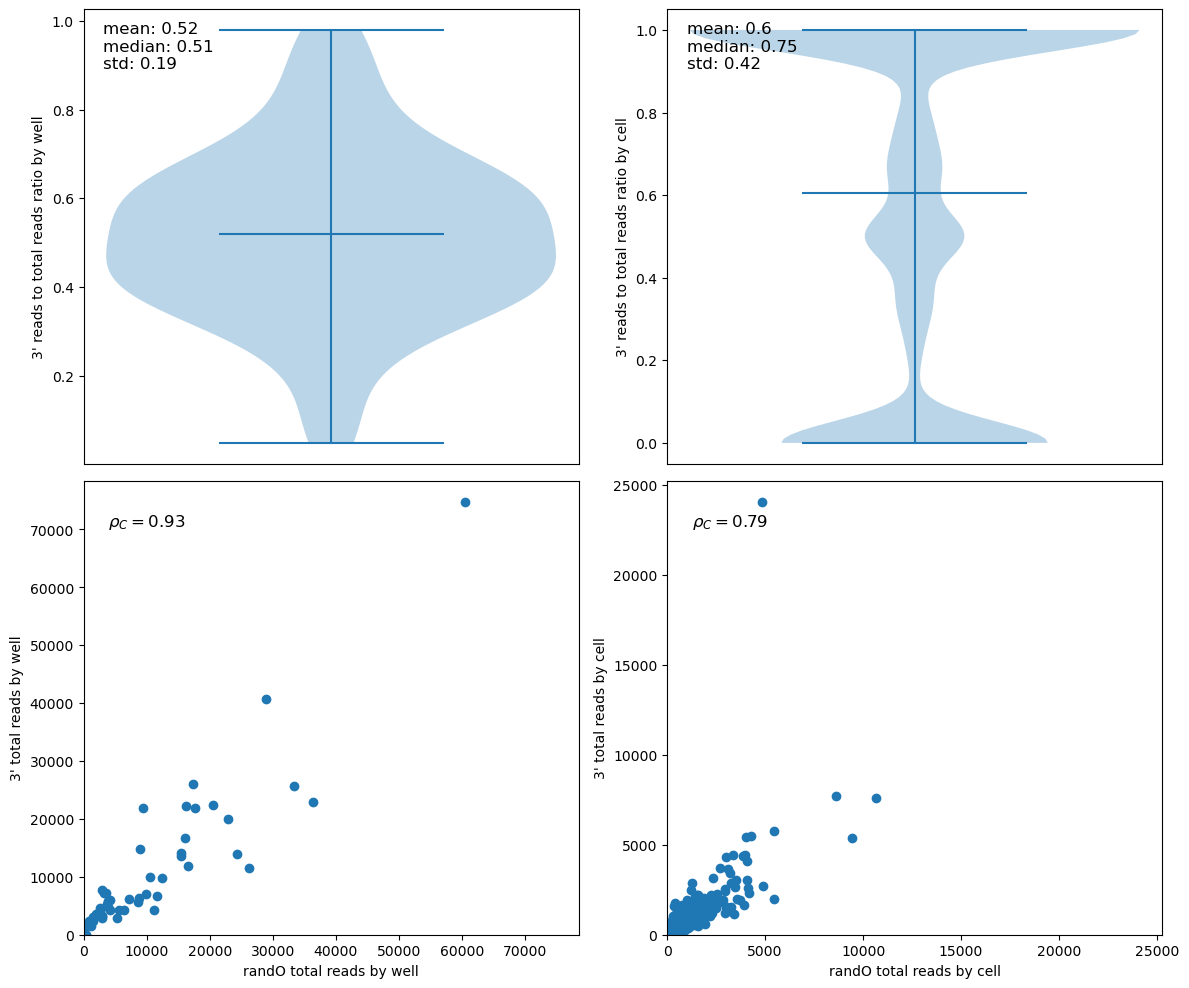

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

well_read_ratios = wells_data.obs[wells_data.obs['polyT']].groupby('well')['n_counts'].sum() / wells_data.obs.groupby('well')['n_counts'].sum()
well_read_ratios = well_read_ratios[well_read_ratios >= 0]  

ax[0,0].violinplot(well_read_ratios.tolist(), showmeans=True, showmedians=False, showextrema=True)
ax[0,0].set_xticks([])
ax[0,0].set_ylabel("3' reads to total reads ratio by well") 
string = "mean: " + str(round(np.mean(well_read_ratios),2)) + "\nmedian: " + str(round(np.median(well_read_ratios),2)) + "\nstd: " + str(round(np.std(well_read_ratios),2))
ax[0,0].text(0.04, 0.87, string, transform=ax[0,0].transAxes, fontsize=12)

cell_read_ratios = parse_data.obs['polyT_reads'] / (parse_data.obs['polyT_reads'] + parse_data.obs['randO_reads'])
cell_read_ratios = cell_read_ratios.fillna(0)

ax[0,1].violinplot(cell_read_ratios.tolist(), showmeans=True, showmedians=False, showextrema=True)
ax[0,1].set_xticks([])
ax[0,1].set_ylabel("3' reads to total reads ratio by cell") 
string = "mean: " + str(round(np.mean(cell_read_ratios),2)) + "\nmedian: " + str(round(np.median(cell_read_ratios),2)) + "\nstd: " + str(round(np.std(cell_read_ratios),2))
ax[0,1].text(0.04, 0.87, string, transform=ax[0,1].transAxes, fontsize=12)

polyT_well_reads = wells_data.obs[wells_data.obs['polyT']].groupby('well')['n_counts'].sum()
randO_well_reads = wells_data.obs[wells_data.obs['randO']].groupby('well')['n_counts'].sum()
well_reads_df = pd.concat([polyT_well_reads, randO_well_reads], axis=1).fillna(0)
well_reads_df = well_reads_df.set_axis(['polyT_reads', 'randO_reads'], axis=1)

ax[1,0].scatter(well_reads_df['randO_reads'], well_reads_df['polyT_reads'])
ax[1,0].set_xlabel('randO total reads by well')
ax[1,0].set_ylabel('3\' total reads by well')
max_lim = max(well_reads_df['randO_reads'].max(), well_reads_df['polyT_reads'].max())
ax[1,0].set_xlim(0, 1.05*max_lim)
ax[1,0].set_ylim(0, 1.05*max_lim)
CCC_r = CCC(well_reads_df['randO_reads'], well_reads_df['polyT_reads'])
ax[1,0].text(0.05, 0.9, r'$\rho_C=%.2f$' % (CCC_r, ), transform=ax[1,0].transAxes, fontsize=12) 

ax[1,1].scatter(parse_data.obs['randO_reads'], parse_data.obs['polyT_reads'])
ax[1,1].set_xlabel('randO total reads by cell')
ax[1,1].set_ylabel('3\' total reads by cell')
max_lim = max(parse_data.obs['randO_reads'].max(), parse_data.obs['polyT_reads'].max())
ax[1,1].set_xlim(0, 1.05*max_lim)
ax[1,1].set_ylim(0, 1.05*max_lim)
CCC_r = CCC(parse_data.obs['randO_reads'], parse_data.obs['polyT_reads'])
ax[1,1].text(0.05, 0.9, r'$\rho_C=%.2f$' % (CCC_r, ), transform=ax[1,1].transAxes, fontsize=12) 

plt.tight_layout()
plt.show()

# Parse Read Analysis

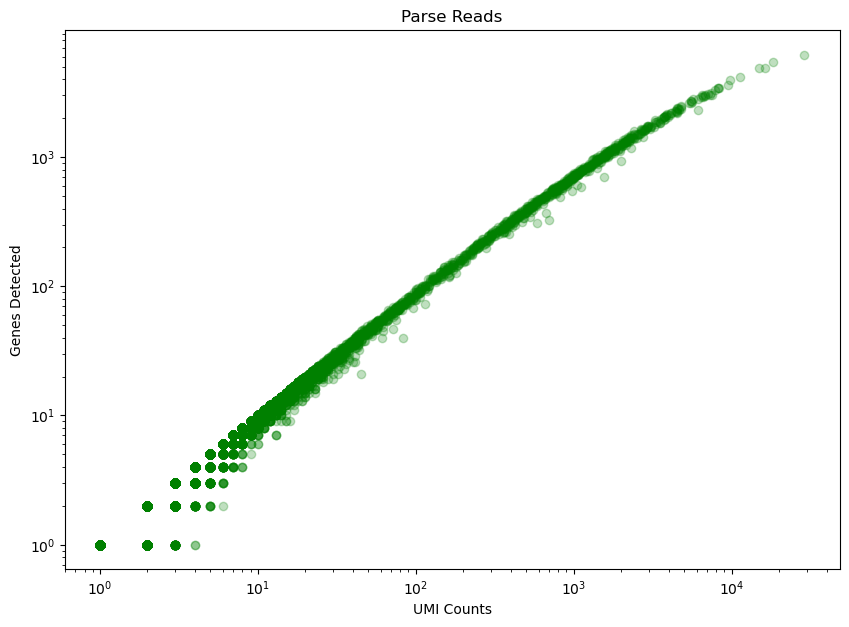

In [9]:
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(parse_data.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(parse_data.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log', nonpositive='clip')
ax.set_title("Parse Reads")

plt.show()

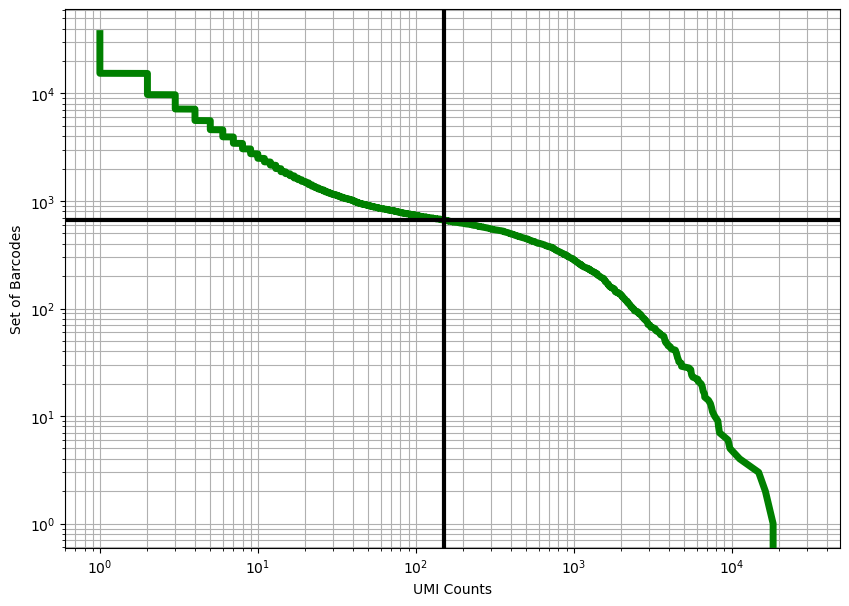

In [10]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
cutoff = 150  #@param {type:"integer"}
knee = np.sort((np.array(parse_data.X.sum(axis=1))).flatten())[::-1]
cell_set = np.arange(len(knee))
num_cells = cell_set[knee > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))


ax.loglog(knee, cell_set, linewidth=5, color="g")
ax.axvline(x=cutoff, linewidth=3, color="k")


ax.axhline(y=num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [11]:
print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold")

664 cells passed the 150 UMI threshold


In [12]:
server = Server(host='http://www.ensembl.org')
dataset = server.marts['ENSEMBL_MART_ENSEMBL'] \
                .datasets['mmusculus_gene_ensembl']

result = dataset.query(attributes=[
    'ensembl_gene_id_version', 'transcript_biotype'
], filters={'transcript_biotype': ['lncRNA']})

In [13]:
lncRNA_genes = set(parse_data.var["gene_codes"].tolist()).intersection(set(result['Gene stable ID version'].tolist()))

In [14]:
# Identify lncRNA genes
parse_data.var["is_lnc"] = np.full(len(parse_data.var_names), False)
parse_data.var.loc[parse_data.var["gene_codes"].isin(list(lncRNA_genes)), ["is_lnc"]] = True

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
parse_data.var["is_mito"] = parse_data.var_names.str.startswith("Mt")
# ribosomal genes
parse_data.var["is_ribo"] = parse_data.var_names.str.startswith(("Rps", "Rpl"))

mito_counts = parse_data[:, parse_data.var['is_mito']].X.sum(axis=1)
ribo_counts = parse_data[:, parse_data.var['is_ribo']].X.sum(axis=1)
nc_counts = parse_data[:, parse_data.var['is_lnc']].X.sum(axis=1)

# Calculate total counts per cell
total_counts = parse_data.X.sum(axis=1)

# Calculate percent mitochondrial and ribosomal gene expression per cell
parse_data.obs['percent_mito'] = np.array(mito_counts / total_counts * 100).flatten()
parse_data.obs['percent_ribo'] = np.array(ribo_counts / total_counts * 100).flatten()
parse_data.obs['percent_lnc'] = np.array(nc_counts / total_counts * 100).flatten()

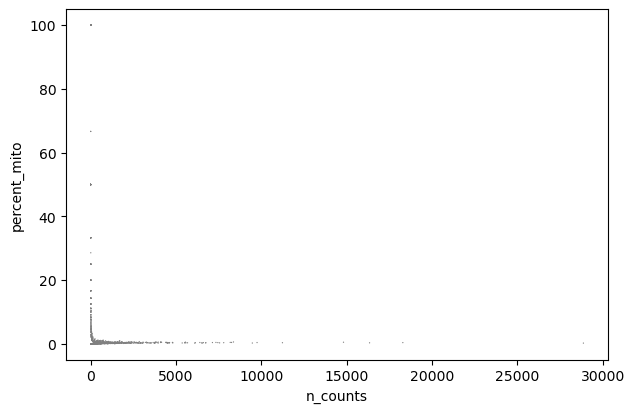

In [15]:
sc.pl.scatter(parse_data, x='n_counts', y='percent_mito')

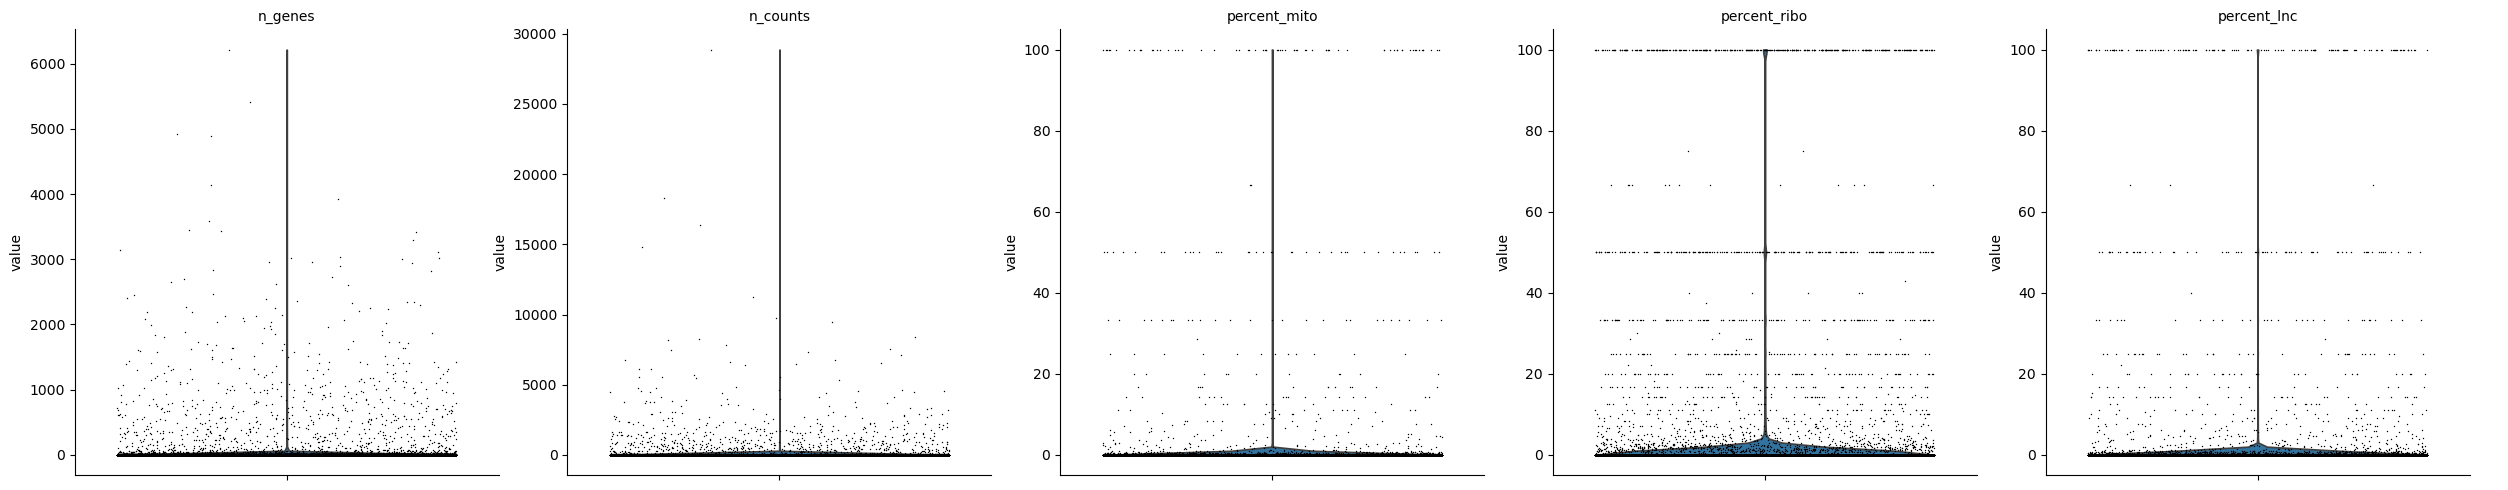

In [16]:
sc.pl.violin(parse_data, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_lnc'], jitter=0.4, multi_panel=True)

In [17]:
genes = parse_data.var
top_genes = genes.sort_values(by='n_cells',ascending=False).head(10).index

gene_dist = []

for gene in top_genes:
    gene_dist.append(np.nan_to_num(parse_data[:,gene].X.toarray().transpose()[0] / np.array(parse_data.obs['n_counts'].tolist()) * 100))

In [18]:
parse_data.var['percent_counts'] = parse_data.X.sum(axis=0).A1 / parse_data.X.sum() * 100

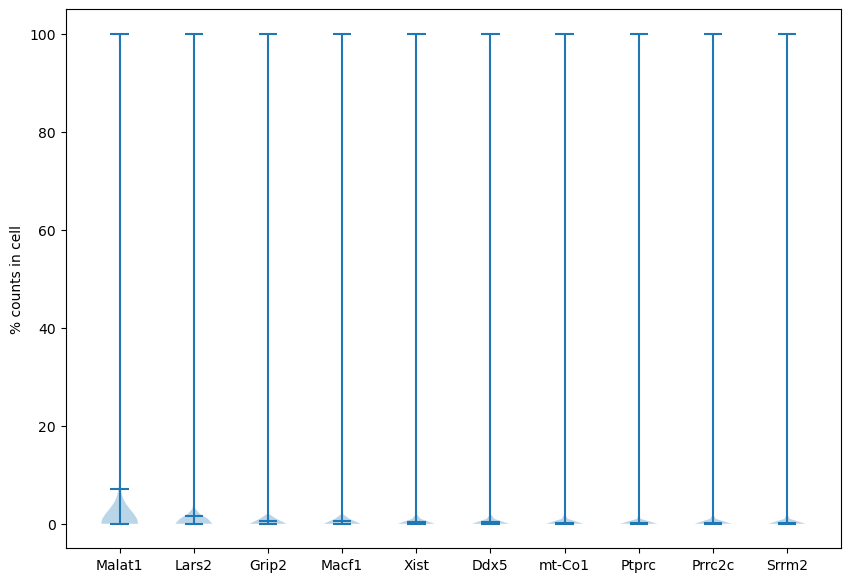

In [19]:
plt.figure(figsize=(10,7))
plt.violinplot(gene_dist, showmeans=True)
plt.xticks(np.arange(1, len(top_genes) + 1), top_genes)
plt.ylabel("% counts in cell")
plt.show()

In [45]:
parse_data.obs.fillna(0, inplace=True)
parse_data.var.fillna(0, inplace=True)
parse_data.write('processed_parse.h5ad', compression="gzip")

# Parse PolyT Read Analysis

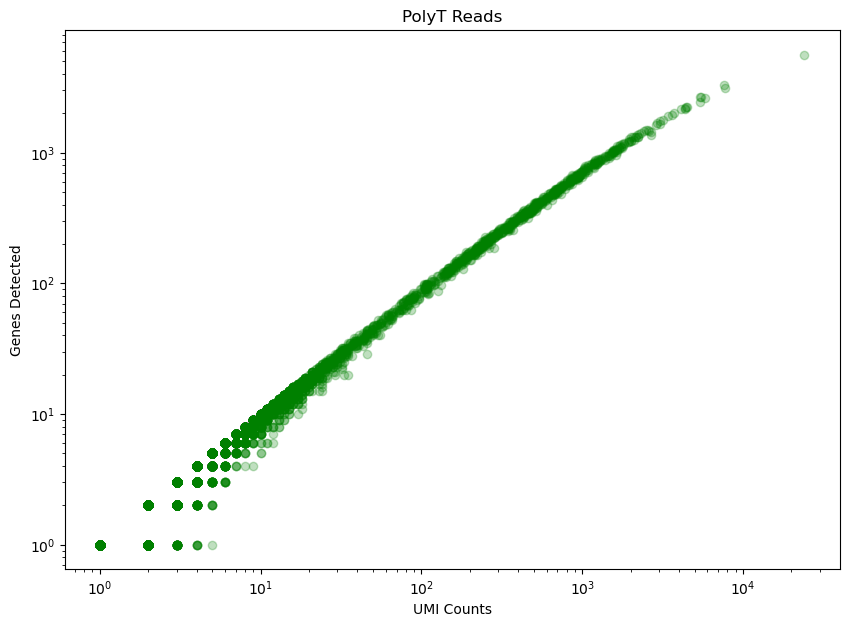

In [21]:
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(polyT_data.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(polyT_data.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log', nonpositive='clip')
ax.set_title("PolyT Reads")

plt.show()

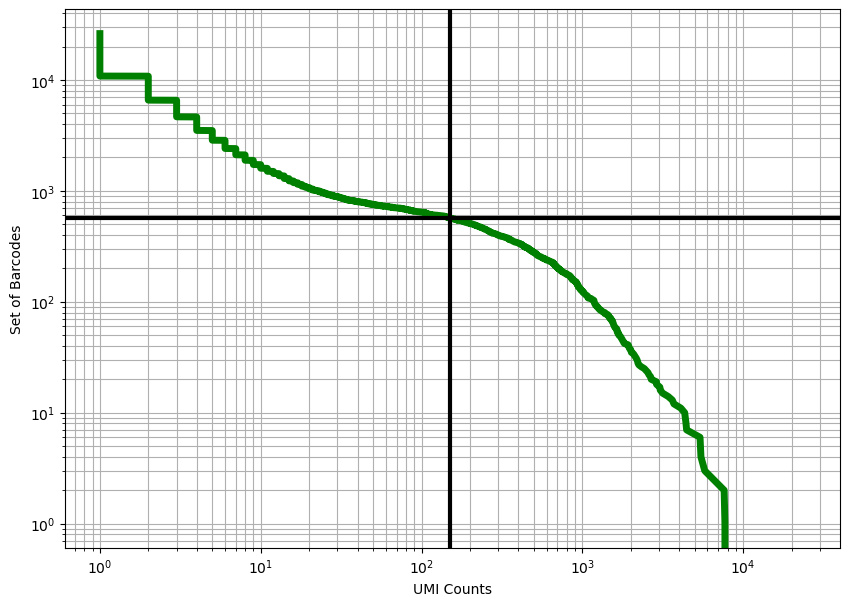

In [22]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
cutoff = 150  #@param {type:"integer"}
knee = np.sort((np.array(polyT_data.X.sum(axis=1))).flatten())[::-1]
cell_set = np.arange(len(knee))
num_cells = cell_set[knee > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))


ax.loglog(knee, cell_set, linewidth=5, color="g")
ax.axvline(x=cutoff, linewidth=3, color="k")


ax.axhline(y=num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [23]:
print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold")

567 cells passed the 150 UMI threshold


In [24]:
lncRNA_genes = set(polyT_data.var["gene_codes"].tolist()).intersection(set(result['Gene stable ID version'].tolist()))

In [25]:
# Identify lncRNA genes
polyT_data.var["is_lnc"] = np.full(len(polyT_data.var_names), False)
polyT_data.var.loc[polyT_data.var["gene_codes"].isin(list(lncRNA_genes)), ["is_lnc"]] = True

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
polyT_data.var["is_mito"] = polyT_data.var_names.str.startswith("Mt")
# ribosomal genes
polyT_data.var["is_ribo"] = polyT_data.var_names.str.startswith(("Rps", "Rpl"))

mito_counts = polyT_data[:, polyT_data.var['is_mito']].X.sum(axis=1)
ribo_counts = polyT_data[:, polyT_data.var['is_ribo']].X.sum(axis=1)
nc_counts = polyT_data[:, polyT_data.var['is_lnc']].X.sum(axis=1)

# Calculate total counts per cell
total_counts = polyT_data.X.sum(axis=1)

# Calculate percent mitochondrial and ribosomal gene expression per cell
polyT_data.obs['percent_mito'] = np.array(mito_counts / total_counts * 100).flatten()
polyT_data.obs['percent_ribo'] = np.array(ribo_counts / total_counts * 100).flatten()
polyT_data.obs['percent_lnc'] = np.array(nc_counts / total_counts * 100).flatten()

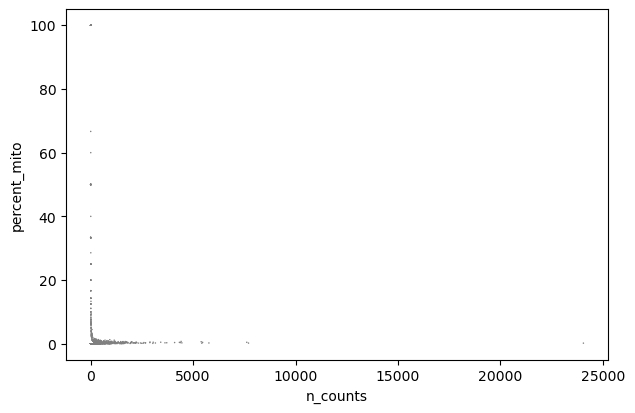

In [26]:
sc.pl.scatter(polyT_data, x='n_counts', y='percent_mito')

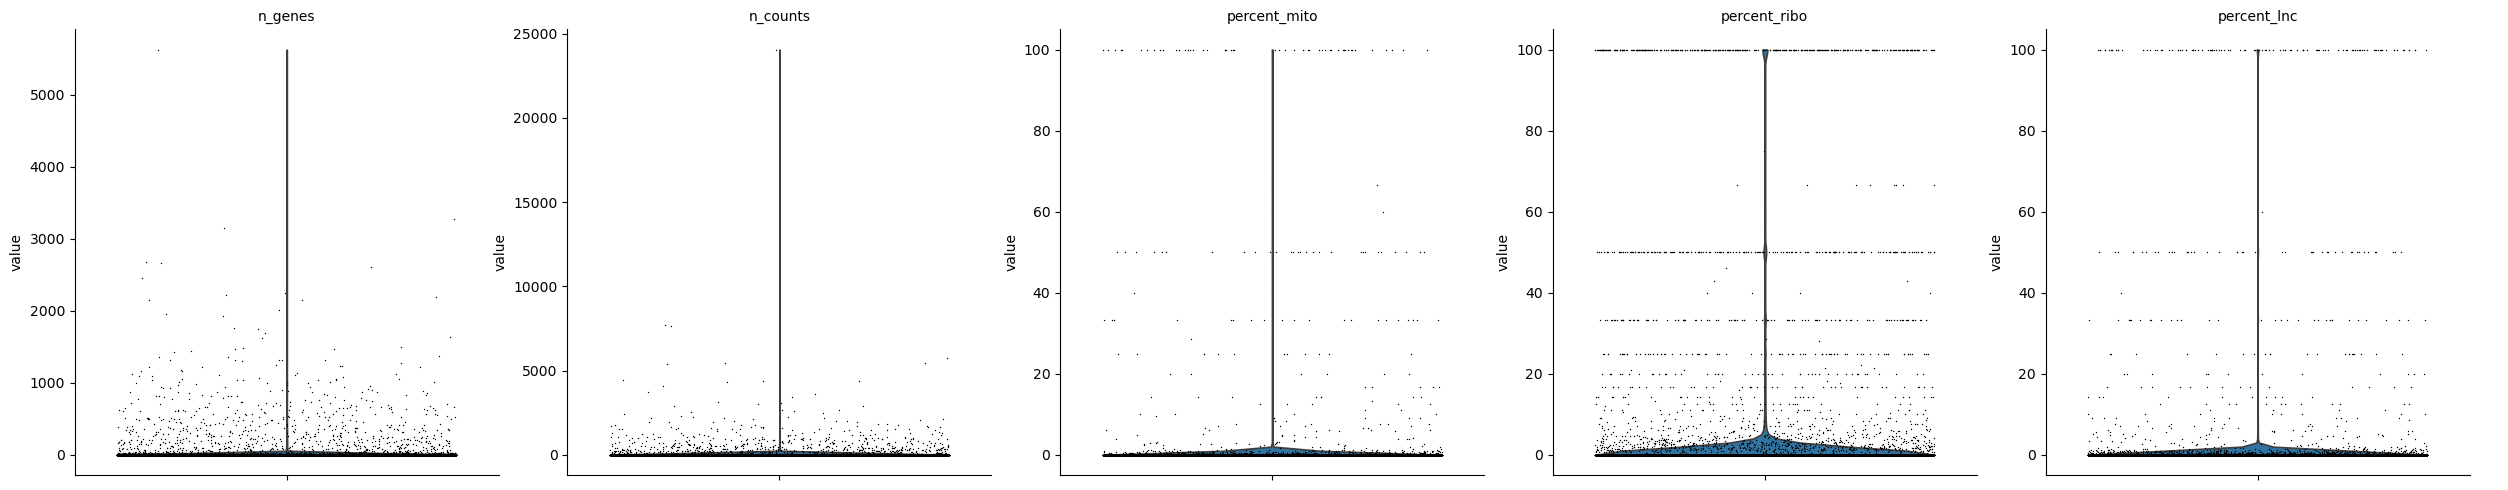

In [27]:
sc.pl.violin(polyT_data, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_lnc'], jitter=0.4, multi_panel=True)

In [28]:
genes = polyT_data.var
top_genes = genes.sort_values(by='n_cells',ascending=False).head(10).index

gene_dist = []

for gene in top_genes:
    gene_dist.append(np.nan_to_num(polyT_data[:,gene].X.toarray().transpose()[0] / np.array(polyT_data.obs['n_counts'].tolist()) * 100))

In [29]:
polyT_data.var['percent_counts'] = polyT_data.X.sum(axis=0).A1 / polyT_data.X.sum() * 100

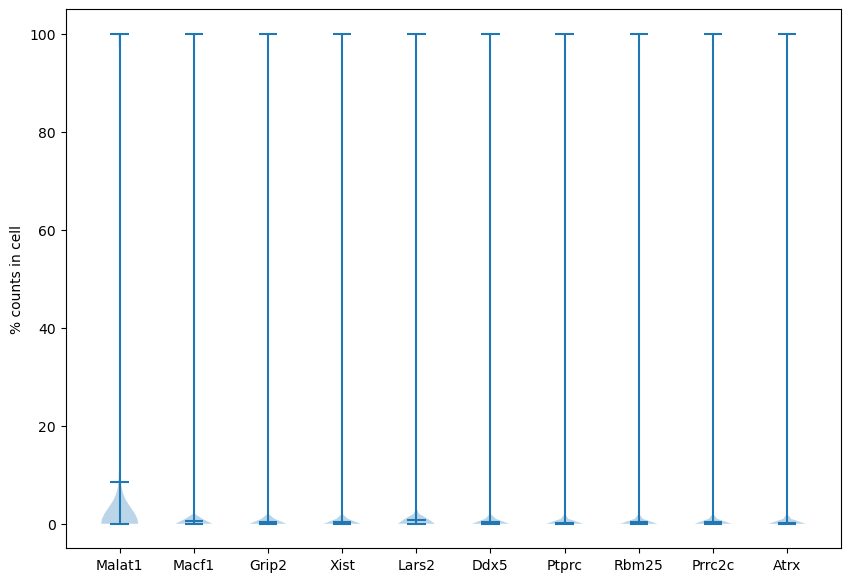

In [30]:
plt.figure(figsize=(10,7))
plt.violinplot(gene_dist, showmeans=True)
plt.xticks(np.arange(1, len(top_genes) + 1), top_genes)
plt.ylabel("% counts in cell")
plt.show()

In [44]:
polyT_data.obs.fillna(0, inplace=True)
polyT_data.var.fillna(0, inplace=True)
polyT_data.write('processed_polyT.h5ad', compression="gzip")

# Parse RandO Read Analysis

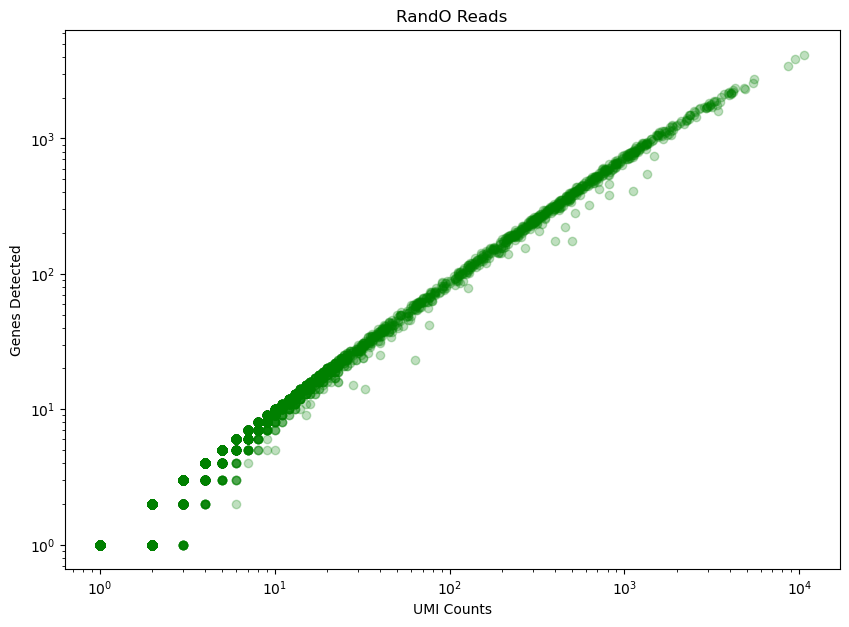

In [32]:
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(randO_data.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(randO_data.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log', nonpositive='clip')
ax.set_title("RandO Reads")

plt.show()

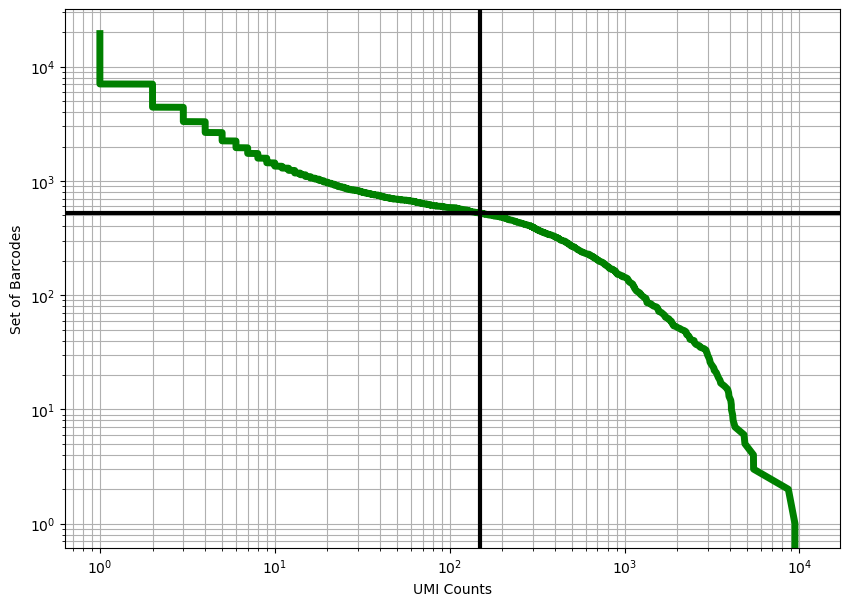

In [33]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
cutoff = 150  #@param {type:"integer"}
knee = np.sort((np.array(randO_data.X.sum(axis=1))).flatten())[::-1]
cell_set = np.arange(len(knee))
num_cells = cell_set[knee > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))


ax.loglog(knee, cell_set, linewidth=5, color="g")
ax.axvline(x=cutoff, linewidth=3, color="k")


ax.axhline(y=num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [34]:
print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold")

523 cells passed the 150 UMI threshold


In [35]:
lncRNA_genes = set(randO_data.var["gene_codes"].tolist()).intersection(set(result['Gene stable ID version'].tolist()))

In [36]:
# Identify lncRNA genes
randO_data.var["is_lnc"] = np.full(len(randO_data.var_names), False)
randO_data.var.loc[randO_data.var["gene_codes"].isin(list(lncRNA_genes)), ["is_lnc"]] = True

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
randO_data.var["is_mito"] = randO_data.var_names.str.startswith("Mt")
# ribosomal genes
randO_data.var["is_ribo"] = randO_data.var_names.str.startswith(("Rps", "Rpl"))

mito_counts = randO_data[:, randO_data.var['is_mito']].X.sum(axis=1)
ribo_counts = randO_data[:, randO_data.var['is_ribo']].X.sum(axis=1)
lnc_counts = randO_data[:, randO_data.var['is_lnc']].X.sum(axis=1)

# Calculate total counts per cell
total_counts = randO_data.X.sum(axis=1)

# Calculate percent mitochondrial and ribosomal gene expression per cell
randO_data.obs['percent_mito'] = np.array(mito_counts / total_counts * 100).flatten()
randO_data.obs['percent_ribo'] = np.array(ribo_counts / total_counts * 100).flatten()
randO_data.obs['percent_lnc'] = np.array(lnc_counts / total_counts * 100).flatten()

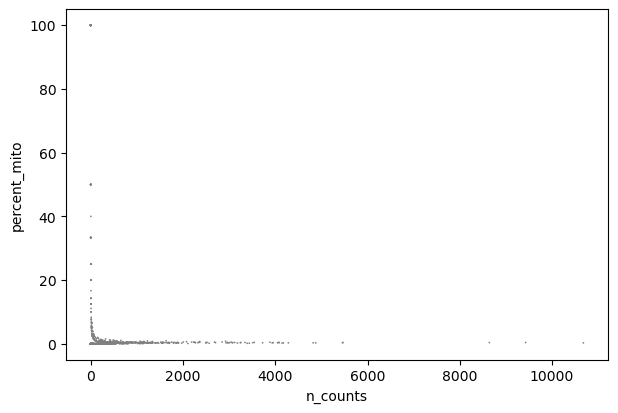

In [37]:
sc.pl.scatter(randO_data, x='n_counts', y='percent_mito')

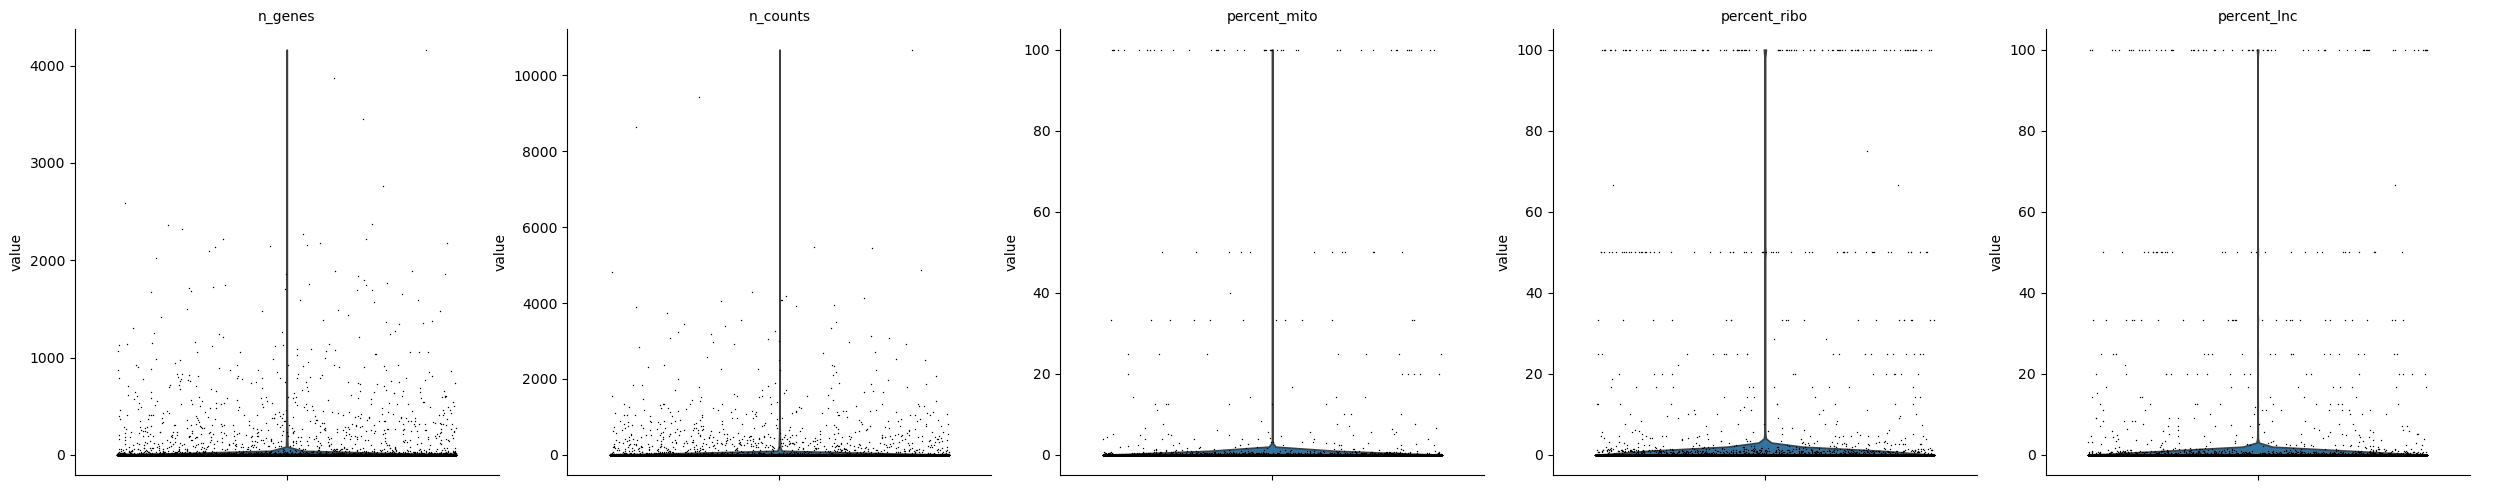

In [38]:
sc.pl.violin(randO_data, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_lnc'], jitter=0.4, multi_panel=True)

In [39]:
genes = randO_data.var
top_genes = genes.sort_values(by='n_cells',ascending=False).head(10).index

gene_dist = []

for gene in top_genes:
    gene_dist.append(np.nan_to_num(randO_data[:,gene].X.toarray().transpose()[0] / np.array(randO_data.obs['n_counts'].tolist()) * 100))

In [40]:
randO_data.var['percent_counts'] = randO_data.X.sum(axis=0).A1  / randO_data.X.sum() * 100

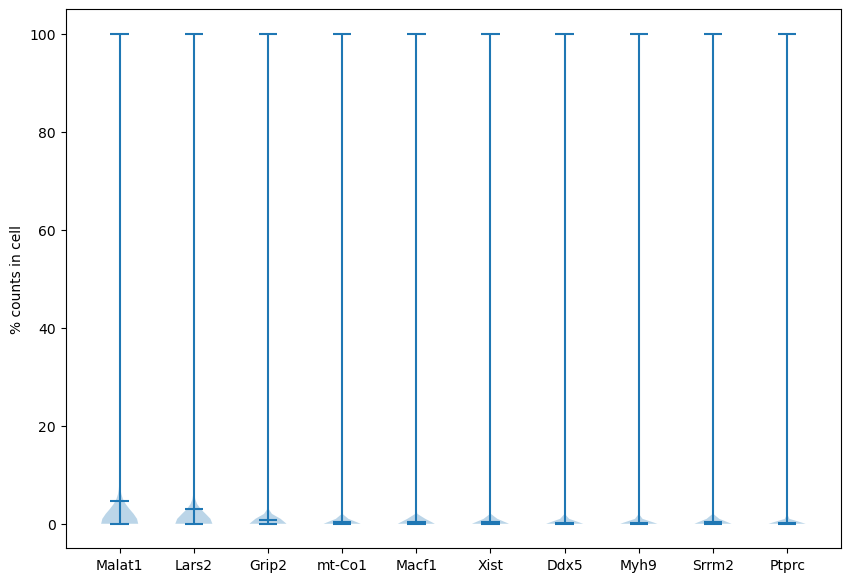

In [41]:
plt.figure(figsize=(10,7))
plt.violinplot(gene_dist, showmeans=True)
plt.xticks(np.arange(1, len(top_genes) + 1), top_genes)
plt.ylabel("% counts in cell")
plt.show()

In [43]:
randO_data.obs.fillna(0, inplace=True)
randO_data.var.fillna(0, inplace=True)
randO_data.write('processed_randO.h5ad', compression="gzip")